In [2]:
import numpy as np # linear algebra
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image
import random

In [3]:
def get_training_data(image_path):
    """Loads an image from the given path into a numpy array."""
    with Image.open(image_path) as img:
        return np.array(img)

### Specify directories

In [4]:
X_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images'
y_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs'

X_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X'
y_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/y'

### Visualization of data

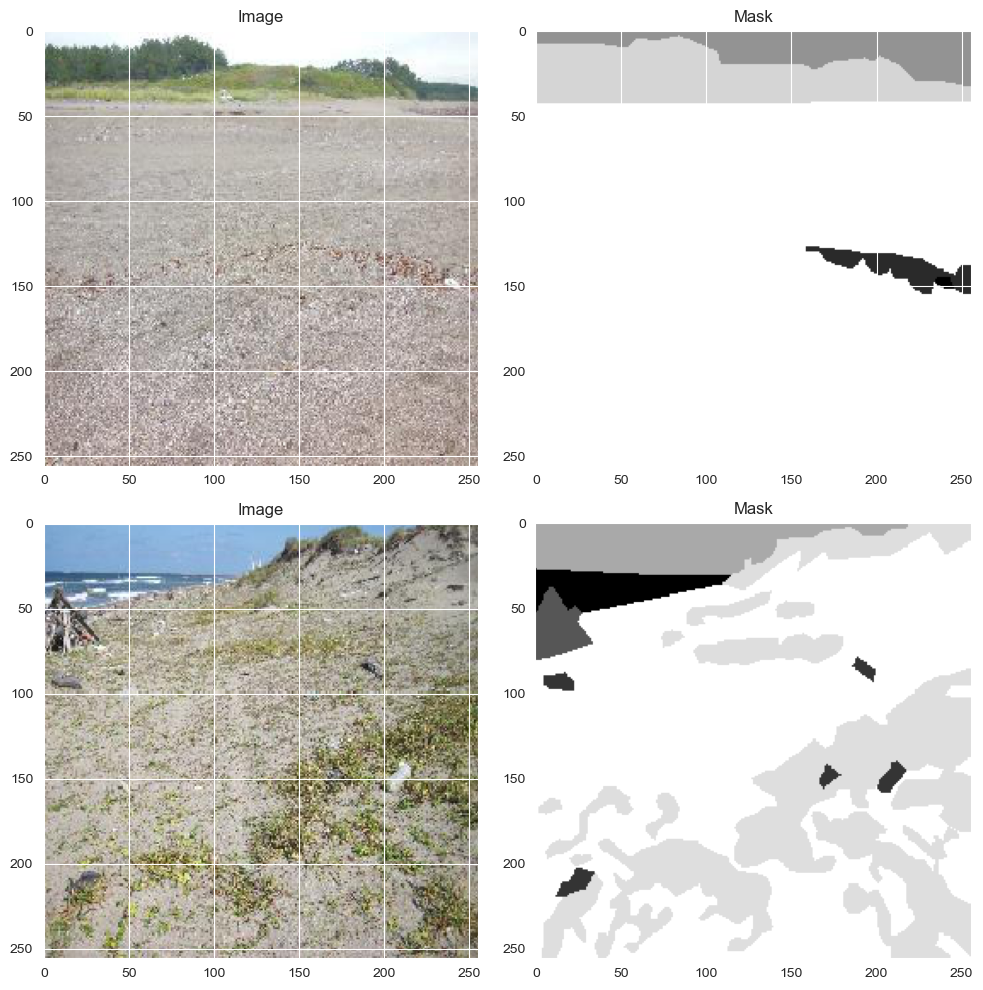

In [6]:
def visualize_data(image_dir, mask_dir, num_examples=2):
    image_files = os.listdir(image_dir)
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    
    for i in range(num_examples):
        img_name = random.choice(image_files)
        img_base_name = os.path.splitext(img_name)[0]
        
        img_path = os.path.join(image_dir, img_name)
        mask_name = mask_files.get(img_base_name, None)
        
        if not mask_name:
            print(f"Mask not found for {img_name}")
            continue
        
        mask_path = os.path.join(mask_dir, mask_name)
        
        image = img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        
    plt.tight_layout()
    plt.grid(False)
    plt.show()

visualize_data('./Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images', './Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs')


### Process images - Research paper states 4:3 aspect ratio for more than 95% of the images

#### Resizing and cropping images

In [7]:
target_width = 400  # 4:3 aspect ratio as given by the research file
target_height = 300

def resize_and_crop(image_path, output_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    aspect_ratio = width / float(height)

    if aspect_ratio > 4/3:
        new_width = int(target_height * aspect_ratio)
        img = cv2.resize(img, (new_width, target_height), interpolation=cv2.INTER_AREA)
        start = (new_width - target_width) // 2
        img = img[:, start:start + target_width]
    else:
        new_height = int(target_width / aspect_ratio)
        img = cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)
        start = (new_height - target_height) // 2
        img = img[start:start + target_height, :]

    cv2.imwrite(output_path, img)

In [8]:
# Iterate over images in X_dir and y_dir, apply resize_and_crop function
for filename in os.listdir(X_dir):
    if filename.endswith(".jpg"):  
        img_path = os.path.join(X_dir, filename)
        output_path = os.path.join(X_path, f"train_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

for filename in os.listdir(y_dir):
    if filename.endswith(".png"): 
        img_path = os.path.join(y_dir, filename)
        output_path = os.path.join(y_path, f"test_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

#### Normalizing

In [19]:
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    
    for image_file, mask_file in zip(image_files, mask_files):
        # Get the image paths
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Load images
        image = load_img(image_path)
        mask = load_img(mask_path, color_mode='grayscale')
    
        # Normalize each image
        image = img_to_array(image) / 255.0
        mask = img_to_array(mask) / 255.0
    
        images.append(image)
        masks.append(mask)
        
    # Return array of the normalized images and masks
    return np.array(images), np.array(masks) 

In [24]:
image_array, mask_array = load_images_and_masks(X_path, y_path)
print(f'Image array dim {image_array.shape}')
print(f'Mask array dim {mask_array.shape}')

Image array dim (3500, 300, 400, 3)
Mask array dim (3500, 300, 400, 1)


array([[[[0.3529412 ],
         [0.3529412 ],
         [0.3529412 ],
         ...,
         [0.3529412 ],
         [0.3529412 ],
         [0.3529412 ]],

        [[0.3529412 ],
         [0.3529412 ],
         [0.3529412 ],
         ...,
         [0.3529412 ],
         [0.3529412 ],
         [0.3529412 ]],

        [[0.3529412 ],
         [0.3529412 ],
         [0.3529412 ],
         ...,
         [0.3529412 ],
         [0.3529412 ],
         [0.3529412 ]],

        ...,

        [[0.5019608 ],
         [0.5019608 ],
         [0.5019608 ],
         ...,
         [0.5019608 ],
         [0.5019608 ],
         [0.5019608 ]],

        [[0.5019608 ],
         [0.5019608 ],
         [0.5019608 ],
         ...,
         [0.5019608 ],
         [0.5019608 ],
         [0.5019608 ]],

        [[0.5019608 ],
         [0.5019608 ],
         [0.5019608 ],
         ...,
         [0.5019608 ],
         [0.5019608 ],
         [0.5019608 ]]],


       [[[0.3529412 ],
         [0.3529412 ],
         [0.35

### Splitting the data and augmenting

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_path, y_path, test_size=0.4, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [17]:
type(y_test)

list

Helper code if things break:

In [ ]:
# import os
# 
# # Define the directory path
# directory = X_dir
# 
# # Iterate over files in the directory
# for filename in os.listdir(directory):
#     if "train" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")
# 
# directory = y_dir
# 
# for filename in os.listdir(directory):
#     if "test" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")